# Placement Optimizer: Data-Driven Profit Strategies

Problem Statement: The goal of this project is to develop predictive models and decision-making strategies to optimize worker placement for two distinct client types:

Type A Clients: These clients pay based on workers' actual productivity, calculated as P × 120 where P represents a worker's productivity.

Type B Clients: These clients pay a flat rate of $250 if a worker's productivity (P) exceeds 0.80.

Assumption : Worker placement incurs a cost of $70 per worker regardless of their productivity or client type. 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict

In [10]:
df = pd.read_csv("/Users/greshashah126/Desktop/Placement Optimizer/garments_worker_productivity.csv")
df.head()

,date,quarter,department,day,team,targeted_productivity,smv,wip,over_time,incentive,idle_time,idle_men,no_of_style_change,no_of_workers,actual_productivity
0,1/1/2015,Quarter1,sweing,Thursday,8,0.80,26.16,1108.0,7080,98,0.0,0,0,59.0,0.940725
1,1/1/2015,Quarter1,finishing,Thursday,1,0.75,3.94,NaN,960,0,0.0,0,0,8.0,0.886500
2,1/1/2015,Quarter1,sweing,Thursday,11,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
3,1/1/2015,Quarter1,sweing,Thursday,12,0.80,11.41,968.0,3660,50,0.0,0,0,30.5,0.800570
4,1/1/2015,Quarter1,sweing,Thursday,6,0.80,25.90,1170.0,1920,50,0.0,0,0,56.0,0.800382


Data Exploration and Cleaning


In [11]:
df.shape

(1197, 15)

In [12]:
df.isnull().sum()

date                       0
quarter                    0
department                 0
day                        0
team                       0
targeted_productivity      0
smv                        0
wip                      506
over_time                  0
incentive                  0
idle_time                  0
idle_men                   0
no_of_style_change         0
no_of_workers              0
actual_productivity        0
dtype: int64

In [13]:
#Displaying unique values in each column
for column in df:
    print(f'{column} : {df[column].unique()}')

date : ['1/1/2015' '1/3/2015' '1/4/2015' '1/5/2015' '1/6/2015' '1/7/2015'
 '1/8/2015' '1/10/2015' '1/11/2015' '1/12/2015' '1/13/2015' '1/14/2015'
 '1/15/2015' '1/17/2015' '1/18/2015' '1/19/2015' '1/20/2015' '1/21/2015'
 '1/22/2015' '1/24/2015' '1/25/2015' '1/26/2015' '1/27/2015' '1/28/2015'
 '1/29/2015' '1/31/2015' '2/1/2015' '2/2/2015' '2/3/2015' '2/4/2015'
 '2/5/2015' '2/7/2015' '2/8/2015' '2/9/2015' '2/10/2015' '2/11/2015'
 '2/12/2015' '2/14/2015' '2/15/2015' '2/16/2015' '2/17/2015' '2/18/2015'
 '2/19/2015' '2/22/2015' '2/23/2015' '2/24/2015' '2/25/2015' '2/26/2015'
 '2/28/2015' '3/1/2015' '3/2/2015' '3/3/2015' '3/4/2015' '3/5/2015'
 '3/7/2015' '3/8/2015' '3/9/2015' '3/10/2015' '3/11/2015']
quarter : ['Quarter1' 'Quarter2' 'Quarter3' 'Quarter4' 'Quarter5']
department : ['sweing' 'finishing ' 'finishing']
day : ['Thursday' 'Saturday' 'Sunday' 'Monday' 'Tuesday' 'Wednesday']
team : [ 8  1 11 12  6  7  2  3  9 10  5  4]
targeted_productivity : [0.8  0.75 0.7  0.65 0.6  0.35 0.5  0.07 0

In [14]:
#drpping wip col, as half of the rows are null 
df = df.drop(columns = 'wip')

In [15]:
#dropping date, as it seems unncessary when quarter is present
df = df.drop(columns = 'date')

In [16]:
#dropping idle_men, as it also seems unncessary with Idle_time being present
df = df.drop(columns = 'idle_men')

In [17]:
#standardising idle_time as max values = 0
df.idle_time = df.idle_time.apply(lambda x:1 if x > 0 else x)

In [18]:
#Converting cols
cat_col = ['quarter', 'department', 'day', 'team', 'targeted_productivity', 'no_of_style_change'] #placed some numerical cols in cat_col
num_col = ['no_of_workers', 'over_time', 'incentive', 'smv']
#oeh
df = pd.get_dummies(df, columns = cat_col, drop_first = True)

In [19]:
# Standardizing num_col
scaler = StandardScaler()
df[num_col] = scaler.fit_transform(df[num_col])

In [20]:
df.head()

,smv,over_time,incentive,idle_time,no_of_workers,actual_productivity,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,...,targeted_productivity_0.35,targeted_productivity_0.4,targeted_productivity_0.5,targeted_productivity_0.6,targeted_productivity_0.65,targeted_productivity_0.7,targeted_productivity_0.75,targeted_productivity_0.8,no_of_style_change_1,no_of_style_change_2
0,1.014552,0.750589,0.373414,0.0,1.099229,0.940725,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
1,-1.016778,-1.077682,-0.238643,0.0,-1.199268,0.886500,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
2,-0.333878,-0.271092,0.073631,0.0,-0.185225,0.800570,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,-0.333878,-0.271092,0.073631,0.0,-0.185225,0.800570,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,0.990783,-0.790895,0.073631,0.0,0.964023,0.800382,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [21]:
df.columns

Index(['smv', 'over_time', 'incentive', 'idle_time', 'no_of_workers',
       'actual_productivity', 'quarter_Quarter2', 'quarter_Quarter3',
       'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing ',
       'department_sweing', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'team_2', 'team_3', 'team_4', 'team_5',
       'team_6', 'team_7', 'team_8', 'team_9', 'team_10', 'team_11', 'team_12',
       'targeted_productivity_0.35', 'targeted_productivity_0.4',
       'targeted_productivity_0.5', 'targeted_productivity_0.6',
       'targeted_productivity_0.65', 'targeted_productivity_0.7',
       'targeted_productivity_0.75', 'targeted_productivity_0.8',
       'no_of_style_change_1', 'no_of_style_change_2'],
      dtype='object')

In [22]:
#Boolean to int conversion
ohe_col = ['quarter_Quarter2', 'quarter_Quarter3',
       'quarter_Quarter4', 'quarter_Quarter5', 'department_finishing ',
       'department_sweing', 'day_Saturday', 'day_Sunday', 'day_Thursday',
       'day_Tuesday', 'day_Wednesday', 'team_2', 'team_3', 'team_4', 'team_5',
       'team_6', 'team_7', 'team_8', 'team_9', 'team_10', 'team_11', 'team_12',
       'targeted_productivity_0.35', 'targeted_productivity_0.4',
       'targeted_productivity_0.5', 'targeted_productivity_0.6',
       'targeted_productivity_0.65', 'targeted_productivity_0.7',
       'targeted_productivity_0.75', 'targeted_productivity_0.8',
       'no_of_style_change_1', 'no_of_style_change_2']

for col in ohe_col:
    if df[col].dtype == 'bool':  # Check if the column has boolean type
        df[col] = df[col].astype(int)

Client A

In [23]:
#Data split
X = df.drop(columns=['actual_productivity'])  # Features
y = df['actual_productivity']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

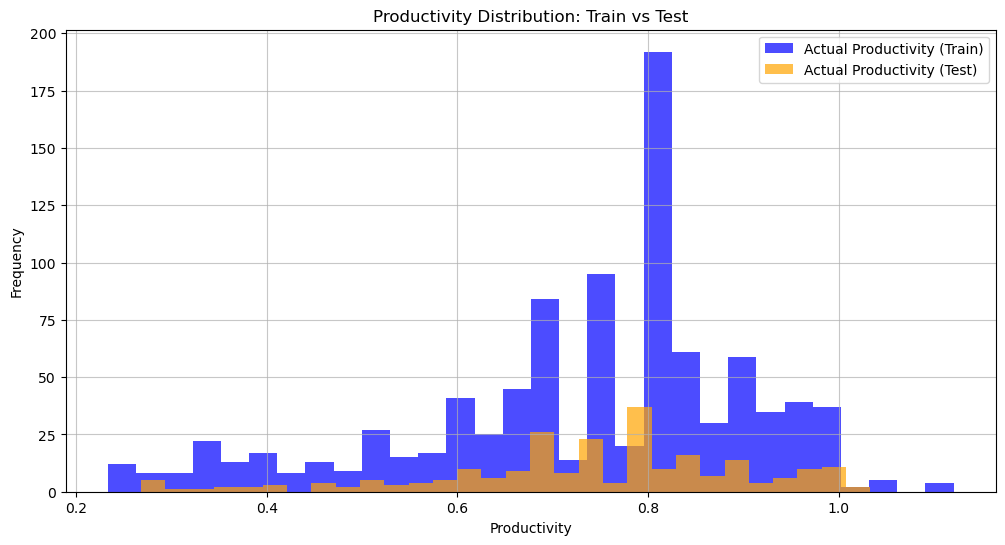

In [24]:
#plotting training and test data to see the highest productivity and similar trends
plt.figure(figsize=(12, 6))
plt.hist(y_train, bins=30, alpha=0.7, label='Actual Productivity (Train)', color='blue')
plt.hist(y_test, bins=30, alpha=0.7, label='Actual Productivity (Test)', color='orange')
plt.title("Productivity Distribution: Train vs Test")
plt.xlabel("Productivity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.7)
plt.show()


XGBoost - Tried to fine tune the model with tuning parameters and extracting irrelevant features

In [25]:
from xgboost import XGBRegressor
xgb_model1 = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_model1.fit(X_train, y_train)

# Make predictions on the test set
y_pred_xgb1 = xgb_model1.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred_xgb1)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb1)

print(f"XGBoost 1 Regression Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R²: {r2}")

XGBoost 1 Regression Results:
Mean Squared Error (MSE): 0.01839081887347599
Root Mean Squared Error (RMSE): 0.13561275335850972
R²: 0.30737813539408876


In [26]:
#xgb_model1 tuning parameters
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 10],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'alpha': [0, 0.1, 1],
    'lambda': [1, 1.5, 2]
}

# Finding the best parameters
random_search = RandomizedSearchCV(xgb_model1, param_distributions=param_grid, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=0, random_state=42, n_jobs=-1)
random_search.fit(X_train, y_train)

# Best Parameters and Model
print("Best Parameters:", random_search.best_params_)
best_model = random_search.best_estimator_

Best Parameters: {'subsample': 0.8, 'n_estimators': 200, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.05, 'lambda': 2, 'gamma': 0, 'colsample_bytree': 0.7, 'alpha': 0}


In [27]:
# xgb_model1 tuned = xgb_model2
xgb_model2 = XGBRegressor(
    subsample=0.8,
    n_estimators=200,
    min_child_weight=3,
    max_depth=3,
    learning_rate=0.05,
    reg_lambda=2,
    gamma=0,
    colsample_bytree=0.7,
    reg_alpha=0,
    random_state=42
)
xgb_model2.fit(X_train, y_train)
y_pred_xgb2 = xgb_model2.predict(X_test)
mse = mean_squared_error(y_test, y_pred_xgb2)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_xgb2)

print(f"XGBoost 2 Regression Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

XGBoost 2 Regression Results:
Mean Squared Error (MSE): 0.014391458849671543
Root Mean Squared Error (RMSE): 0.11996440659492107
R² Score: 0.45799917168262794


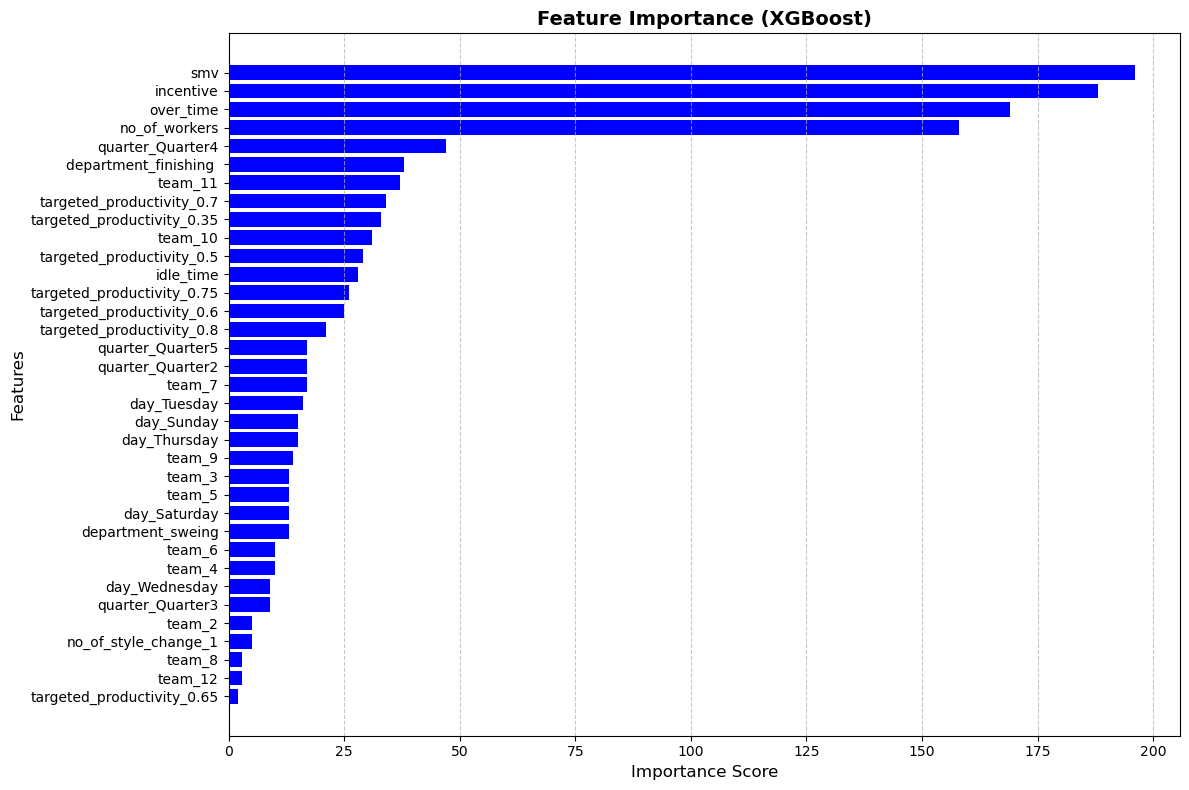

In [28]:
# Extract feature importance 
importance = xgb_model2.get_booster().get_score(importance_type='weight')
importance_df = pd.DataFrame(importance.items(), columns=['Feature', 'Importance']).sort_values(by='Importance', ascending=False)

# Plotting
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='blue')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Feature Importance (XGBoost)', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [29]:
low_feature_xgb2 = ['targeted_productivity_0.65', 'team_12']
X_train_reduced = X_train.drop(columns=low_feature_xgb2)
X_test_reduced = X_test.drop(columns=low_feature_xgb2)

In [30]:
#xgb final 
xgb_model2.fit(X_train_reduced, y_train)
y_pred_fi = xgb_model2.predict(X_test_reduced)
mse = mean_squared_error(y_test, y_pred_fi)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred_fi)

print(f"XGBoost 2 Regression w/ feature importance Results:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

XGBoost 2 Regression w/ feature importance Results:
Mean Squared Error (MSE): 0.014068813788739183
Root Mean Squared Error (RMSE): 0.11861203053965134
R² Score: 0.4701503991644643


Random Forest Regressor - Finalised Model for prediction

In [31]:
rf_model1 = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model1.fit(X_train, y_train)

# Predict on the test data
y_pred_rf1 = rf_model1.predict(X_test)

# Calculate evaluation metrics
mse_rf1 = mean_squared_error(y_test, y_pred_rf1)
rmse_rf1 = np.sqrt(mse_rf1)
r2_rf1 = r2_score(y_test, y_pred_rf1)

# Print the results
print("Random Forest Regressor Model 1 Results:")
print(f"Mean Squared Error (MSE): {mse_rf1}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf1}")
print(f"R² Score: {r2_rf1}")

Random Forest Regressor Model 1 Results:
Mean Squared Error (MSE): 0.014797344915987509
Root Mean Squared Error (RMSE): 0.1216443377884376
R² Score: 0.4427129810021915


In [32]:
from sklearn.model_selection import RandomizedSearchCV

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [100, 200, 300],               # Number of trees in the forest
    'max_depth': [None, 10, 20, 30],                # Max depth of trees
    'min_samples_split': [2, 5, 10],                # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],                  # Minimum samples at a leaf node
    'max_features': ['auto', 'sqrt', 'log2'],      # Number of features to consider for best split
    'bootstrap': [True, False]                      # Whether to use bootstrap samples
}

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_model1, param_distributions=param_grid, 
                                   n_iter=100, cv=3, n_jobs=-1, verbose=0, 
                                   scoring='neg_mean_squared_error', random_state=42)

# Fit RandomizedSearchCV
random_search.fit(X_train, y_train)

# Get best parameters
best_params_random = random_search.best_params_
print("Best Hyperparameters from Randomized Search: ", best_params_random)


Best Hyperparameters from Randomized Search:  {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}


In [33]:
#Final Model
rf_model2 = RandomForestRegressor(n_estimators=200, 
                                     min_samples_split = 5, 
                                     min_samples_leaf = 1, 
                                     max_features = 'sqrt', 
                                     max_depth = 30, 
                                     bootstrap = False,
                                     random_state=42)
rf_model2.fit(X_train, y_train)

# Predict on the test data
y_pred_rf2 = rf_model2.predict(X_test)

# Calculate evaluation metrics
mse_rf2 = mean_squared_error(y_test, y_pred_rf2)
rmse_rf2 = np.sqrt(mse_rf2)
r2_rf2 = r2_score(y_test, y_pred_rf2)

# Print the results
print("Random Forest Regressor Model 2 Results:")
print(f"Mean Squared Error (MSE): {mse_rf2}")
print(f"Root Mean Squared Error (RMSE): {rmse_rf2}")
print(f"R² Score: {r2_rf2}")

Random Forest Regressor Model 2 Results:
Mean Squared Error (MSE): 0.012976525607975544
Root Mean Squared Error (RMSE): 0.11391455397786336
R² Score: 0.5112873752639151


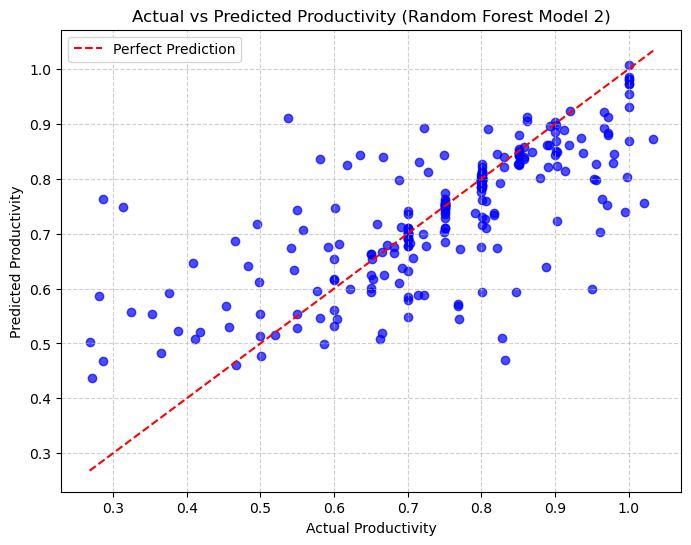

In [34]:
# Plot actual vs predicted productivity
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_rf2, color='blue', alpha=0.7)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')
plt.title('Actual vs Predicted Productivity (Random Forest Model 2)')
plt.xlabel('Actual Productivity')
plt.ylabel('Predicted Productivity')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

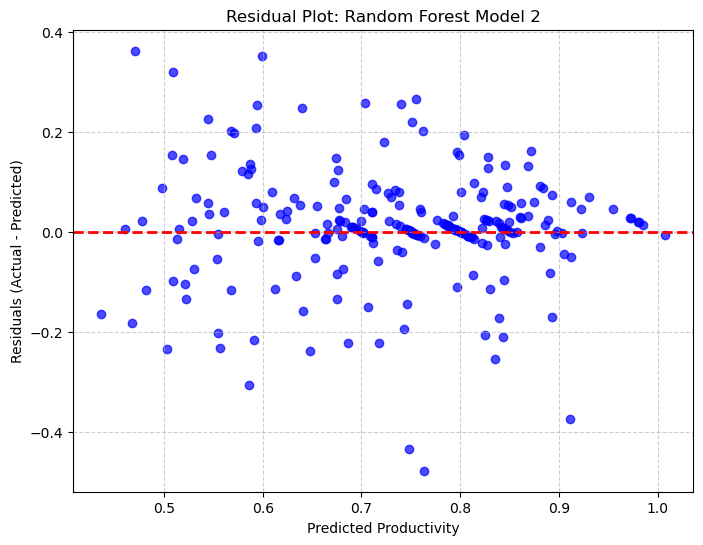

In [35]:
# Calculate residuals
residuals = y_test - y_pred_rf2

# Create the residual plot
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_rf2, residuals, alpha=0.7, color='blue')
plt.axhline(y=0, color='r', linestyle='--', linewidth=2)
plt.title('Residual Plot: Random Forest Model 2')
plt.xlabel('Predicted Productivity')
plt.ylabel('Residuals (Actual - Predicted)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

Optimal Threshold (Training Set): 0.578
Total Profit (Test Set with Optimal Threshold): $4855.16


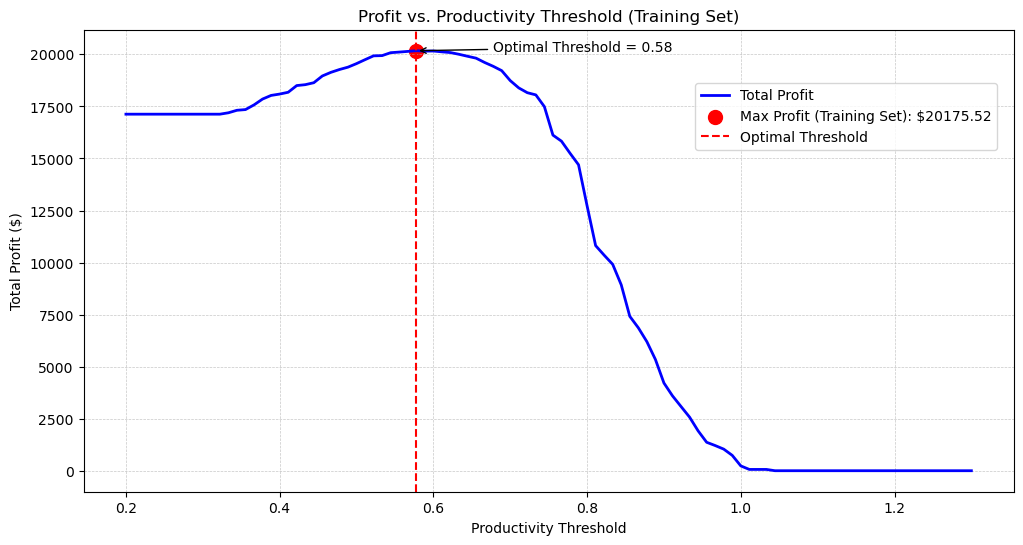

In [36]:
#Calculating value of the model
# Predict on training set
y_train_pred_rf = rf_model2.predict(X_train)

# Define a range of thresholds and calculate profits for training set
thresholds = np.linspace(0.2, 1.3, 100)
profits_train = []

for t in thresholds:
    # Decision rule: Place workers with predicted productivity > threshold
    decisions_train = (y_train_pred_rf > t)
    # Calculate profit using actual productivity
    profit_per_worker_train = (y_train * 120) - 70
    total_profit_train = profit_per_worker_train[decisions_train].sum()
    profits_train.append(total_profit_train)

# Find optimal threshold
optimal_threshold_train = thresholds[np.argmax(profits_train)]
print(f"Optimal Threshold (Training Set): {optimal_threshold_train:.3f}")

# Apply optimal threshold on the test set
y_test_pred_rf = rf_model2.predict(X_test)
decisions_test = (y_test_pred_rf > optimal_threshold_train)
profit_per_worker_test = (y_test * 120) - 70
total_profit_test = profit_per_worker_test[decisions_test].sum()

print(f"Total Profit (Test Set with Optimal Threshold): ${total_profit_test:.2f}")

# Plotting train/test values with threshold
plt.figure(figsize=(12, 6))
plt.plot(thresholds, profits_train, color='blue', label='Total Profit', linewidth=2)

# Highlight the optimal threshold and its corresponding profit
optimal_profit = max(profits_train)
plt.scatter(optimal_threshold_train, optimal_profit, color='red', s=100, label=f'Max Profit (Training Set): ${optimal_profit:.2f}')

# Add annotations for the optimal threshold
plt.annotate(
    f'Optimal Threshold = {optimal_threshold_train:.2f}',
    xy=(optimal_threshold_train, optimal_profit),
    xytext=(optimal_threshold_train + 0.1, optimal_profit - 50),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Add grid, labels, and legend
plt.title('Profit vs. Productivity Threshold (Training Set)')
plt.xlabel('Productivity Threshold')
plt.ylabel('Total Profit ($)')
plt.axvline(optimal_threshold_train, color='red', linestyle='--', label='Optimal Threshold')
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.82, 0.9))

# Show the plot
plt.show()

Number of Workers Placed (Model-Based): 209
Total Profit (Model-Based Placement): $4855.16
Total Profit (Random Placement): $4146.00


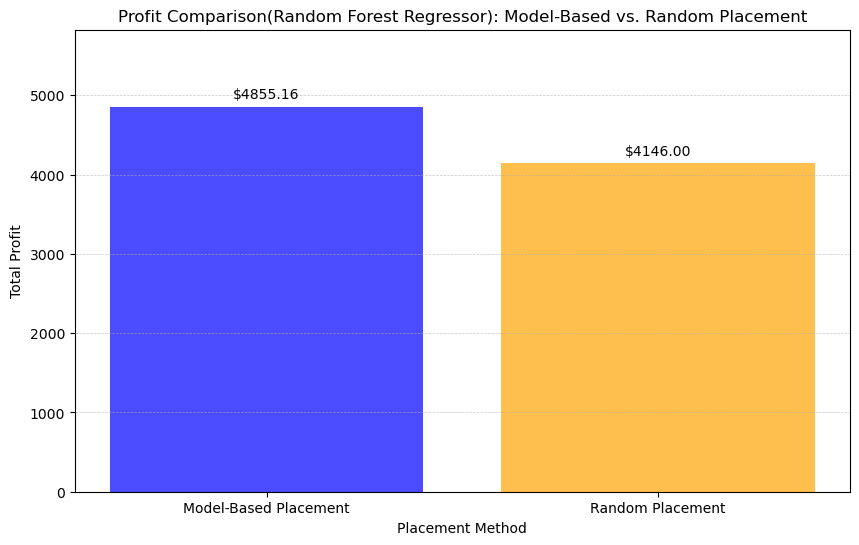

In [37]:
# Calculate profit for workers placed using model predictions
model_based_placements = decisions_test.sum()  # Number of workers placed by the model
model_total_profit = total_profit_test  # Profit from model-based placements


# Simulate random placements
np.random.seed(42)
# Random placement for the same number of workers
num_workers_placed = sum(decisions_test)
random_decisions = np.random.choice([0, 1], size=len(y_test), p=[1 - num_workers_placed / len(y_test), num_workers_placed / len(y_test)])
random_profit = profit_per_worker_test[random_decisions == 1].sum()


print(f"Number of Workers Placed (Model-Based): {model_based_placements}")
print(f"Total Profit (Model-Based Placement): ${model_total_profit:.2f}")
print(f"Total Profit (Random Placement): ${random_profit:.2f}")

#Plotting Model vs Random
plt.figure(figsize=(10, 6))

# Bar plot for model-based vs. random profits
labels = ['Model-Based Placement', 'Random Placement']
profits = [model_total_profit, random_profit]

# Plotting the bar graph
plt.bar(labels, profits, color=['blue', 'orange'], alpha=0.7)

# Adding labels to the bars
for i, v in enumerate(profits):
    plt.text(i, v + 100, f'${v:.2f}', ha='center', fontsize=10, color='black')

# Set titles and labels
plt.title('Profit Comparison(Random Forest Regressor): Model-Based vs. Random Placement')
plt.xlabel('Placement Method')
plt.ylabel('Total Profit')
plt.ylim(0, max(profits) * 1.2)  # Increase y-axis limit for better label visibility
plt.grid(True, axis = 'y', linestyle='--', linewidth=0.5, alpha=0.7)

# Show the plot
plt.show()


Client B

In [38]:
df2 = df.copy()

In [39]:
df2['productivity>0.8'] = df2['actual_productivity'] > 0.8

In [40]:
df2['productivity>0.8'] = df2['productivity>0.8'].astype(int)

In [41]:
df2.drop(columns = 'actual_productivity', inplace=True)
df.head()

,smv,over_time,incentive,idle_time,no_of_workers,actual_productivity,quarter_Quarter2,quarter_Quarter3,quarter_Quarter4,quarter_Quarter5,...,targeted_productivity_0.35,targeted_productivity_0.4,targeted_productivity_0.5,targeted_productivity_0.6,targeted_productivity_0.65,targeted_productivity_0.7,targeted_productivity_0.75,targeted_productivity_0.8,no_of_style_change_1,no_of_style_change_2
0,1.014552,0.750589,0.373414,0.0,1.099229,0.940725,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,-1.016778,-1.077682,-0.238643,0.0,-1.199268,0.886500,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,-0.333878,-0.271092,0.073631,0.0,-0.185225,0.800570,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,-0.333878,-0.271092,0.073631,0.0,-0.185225,0.800570,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,0.990783,-0.790895,0.073631,0.0,0.964023,0.800382,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [42]:
X = df2.drop(columns=['productivity>0.8'])  # Features
y = df2['productivity>0.8']  # Target variable


# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [43]:
from xgboost import XGBClassifier

# Initialize the XGBoost Classifier
xgb_classifier = XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, random_state=42, use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred_xgb = xgb_classifier.predict(X_test)

# Evaluate the model
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
precision_xgb = precision_score(y_test, y_pred_xgb)
recall_xgb = recall_score(y_test, y_pred_xgb)
f1_xgb = f1_score(y_test, y_pred_xgb)

# Print the evaluation metrics
print("XGBoost Classifier Results:")
print(f"Accuracy: {accuracy_xgb:.2f}")
print(f"Precision: {precision_xgb:.2f}")
print(f"Recall: {recall_xgb:.2f}")
print(f"F1 Score: {f1_xgb:.2f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_xgb))

XGBoost Classifier Results:
Accuracy: 0.87
Precision: 0.87
Recall: 0.85
F1 Score: 0.86

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.89      0.88       128
           1       0.87      0.85      0.86       112

    accuracy                           0.87       240
   macro avg       0.87      0.87      0.87       240
weighted avg       0.87      0.87      0.87       240



Optimal Threshold:0.42
Placed Workers (Train): 470
Profit on Testing Data at Training Optimal Threshold: $16020.00
True Positives (Test): 96
False Positives (Test): 18
Placed Workers (Test): 114


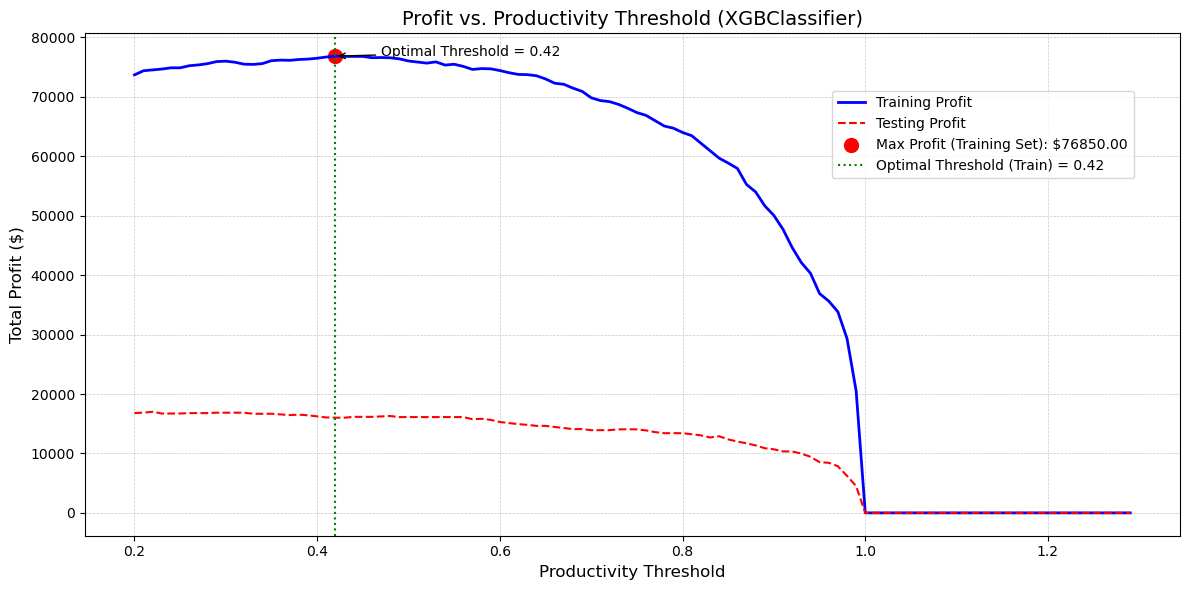

In [44]:
#Retrain the model for predictions
xgb_classifier.fit(X_train, y_train)

# Step 2: Get predicted probabilities for both training and test datasets
y_train_proba = xgb_classifier.predict_proba(X_train)[:, 1]
y_test_proba = xgb_classifier.predict_proba(X_test)[:, 1]

# Step 3: Threshold analysis
thresholds = np.arange(0.2, 1.3, 0.01)
train_results = []
test_results = []

for threshold in thresholds:
    # Training predictions
    y_train_pred = (y_train_proba >= threshold).astype(int)
    cm_train = confusion_matrix(y_train, y_train_pred)
    TN_train, FP_train, FN_train, TP_train = cm_train.ravel()
    
    # Calculate training profit
    placed_workers_train = TP_train + FP_train
    profit_train = TP_train * 250 - placed_workers_train * 70
    train_results.append(profit_train)
    
    # Test predictions
    y_test_pred = (y_test_proba >= threshold).astype(int)
    cm_test = confusion_matrix(y_test, y_test_pred)
    TN_test, FP_test, FN_test, TP_test = cm_test.ravel()
    
    # Calculate test profit
    placed_workers_test = TP_test + FP_test
    profit_test = TP_test * 250 - placed_workers_test * 70
    test_results.append(profit_test)

# Step 4: Find optimal threshold from training data
optimal_threshold_train = thresholds[np.argmax(train_results)]
max_profit_train = max(train_results)

# Step 5: Calculate Test Metrics at Optimal Threshold
y_test_pred_optimal = (y_test_proba >= optimal_threshold_train).astype(int)
cm_test_optimal = confusion_matrix(y_test, y_test_pred_optimal)
TN_test_optimal, FP_test_optimal, FN_test_optimal, TP_test_optimal = cm_test_optimal.ravel()

# Metrics for test data
profit_test_optimal = TP_test_optimal * 250 - (TP_test_optimal + FP_test_optimal) * 70
placed_workers_test_optimal = TP_test_optimal + FP_test_optimal

# Metrics for train data at optimal threshold
y_train_pred_optimal = (y_train_proba >= optimal_threshold_train).astype(int)
cm_train_optimal = confusion_matrix(y_train, y_train_pred_optimal)
TN_train_optimal, FP_train_optimal, FN_train_optimal, TP_train_optimal = cm_train_optimal.ravel()

# Metrics for training data
profit_train_optimal = TP_train_optimal * 250 - (TP_train_optimal + FP_train_optimal) * 70
placed_workers_train_optimal = TP_train_optimal + FP_train_optimal

# Print Results for Training Data at Optimal Threshold
print(f"Optimal Threshold:{optimal_threshold_train:.2f}")
print(f"Placed Workers (Train): {placed_workers_train_optimal}")

# Print Results
print(f"Profit on Testing Data at Training Optimal Threshold: ${profit_test_optimal:.2f}")
print(f"True Positives (Test): {TP_test_optimal}")
print(f"False Positives (Test): {FP_test_optimal}")
print(f"Placed Workers (Test): {placed_workers_test_optimal}")


# Step 6: Plot the results
plt.figure(figsize=(12, 6))

# Plot training profit (blue line)
plt.plot(thresholds, train_results, color='blue', label='Training Profit', linewidth=2)

# Plot testing profit (red dashed line)
plt.plot(thresholds, test_results, color='red', linestyle='--', label='Testing Profit')

# Highlight the optimal threshold and its corresponding profit
plt.scatter(optimal_threshold_train, max_profit_train, color='red', s=100, label=f'Max Profit (Training Set): ${max_profit_train:.2f}')

# Add annotations for the optimal threshold
plt.annotate(
    f'Optimal Threshold = {optimal_threshold_train:.2f}',
    xy=(optimal_threshold_train, max_profit_train),
    xytext=(optimal_threshold_train + 0.05, max_profit_train - 50),
    arrowprops=dict(facecolor='black', arrowstyle='->'),
    fontsize=10
)

# Add grid, labels, and legend
plt.title('Profit vs. Productivity Threshold (XGBClassifier)', fontsize=14)
plt.xlabel('Productivity Threshold', fontsize=12)
plt.ylabel('Total Profit ($)', fontsize=12)
plt.axvline(optimal_threshold_train, color='green', linestyle=':', label=f'Optimal Threshold (Train) = {optimal_threshold_train:.2f}')
plt.grid(visible=True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend(fontsize=10, loc='upper center', bbox_to_anchor=(0.82, 0.9))

# Show the plot
plt.tight_layout()
plt.show()


In [45]:
np.random.seed(42)
# Step 1: Simulate Random Placement based on XGBoost Threshold
# For the sake of randomness, generate predicted probabilities similar to XGBoost predictions
y_random_proba = np.random.uniform(0, 1, size=len(y_test))  # Random probabilities between 0 and 1

# Step 2: Apply the same threshold that was used for the XGBoost classifier
threshold = optimal_threshold_train  # XGBoost optimal threshold from training set

# Random worker placement based on the threshold (like XGBoost classifier decision rule)
y_random_pred = (y_random_proba >= threshold).astype(int)

# Step 3: Confusion matrix for random predictions
cm_random_test = confusion_matrix(y_test, y_random_pred)
TN_random_test, FP_random_test, FN_random_test, TP_random_test = cm_random_test.ravel()

# Step 4: Calculate the profit for the test set
placed_workers_random_test = placed_workers_test_optimal  # same as xgb placed workers
profit_random_test = TP_random_test * 250 - placed_workers_random_test * 70  # Profit calculation

# Step 5: Print Results for Random Placement
print(f"Max Profit with Random Worker Placement (Test) at XGBoost Threshold of {threshold:.2f}: ${profit_random_test:.2f}")
print(f"Placed Workers (Random Test): {placed_workers_random_test}")


Max Profit with Random Worker Placement (Test) at XGBoost Threshold of 0.42: $7020.00
Placed Workers (Random Test): 114


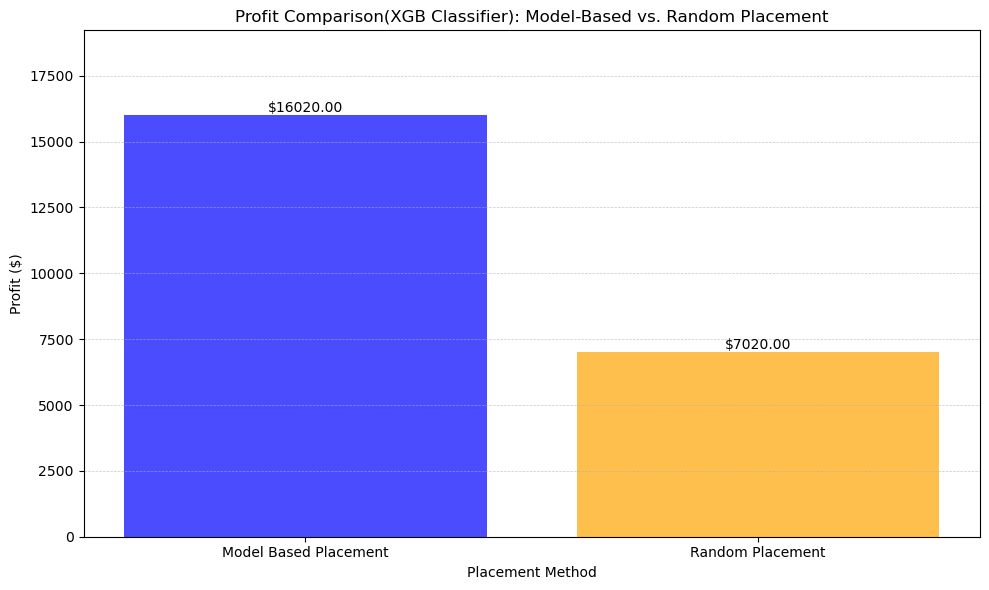

In [47]:
# Bar chart comparison
profits = [profit_test_optimal, profit_random_test]
labels = ['Model Based Placement', 'Random Placement']

plt.figure(figsize=(10, 6))
plt.bar(labels, profits, color=['blue', 'orange'], alpha=0.7)

# Adding labels to the bars
for i, v in enumerate(profits):
    plt.text(i, v + 100, f'${v:.2f}', ha='center', fontsize=10, color='black')

# Add titles and labels
plt.title('Profit Comparison(XGB Classifier): Model-Based vs. Random Placement')
plt.xlabel('Placement Method')
plt.ylabel('Profit ($)')
plt.ylim(0, max(profits) * 1.2)  # Increase y-axis limit for better label visibility
plt.grid(True, axis = 'y', linestyle='--', linewidth=0.5, alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()
